# preparation for data for the Gender and age classification model


### **Step #1**: Import necessary Libraries and file and folder path and model name

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import random
#########################################################33
from openpyxl import Workbook
from shutil import copyfile
########################################################
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
#######################################################
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
###########################################
# This is a simple keras or tensorflow.keras library import for CNN 
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Input,Dropout
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
##################################################
from imblearn.under_sampling import RandomUnderSampler
from keras.callbacks import Callback
#######################################################
from scipy.stats import skew, kurtosis

# This is a simple keras library import for CNN 
print("cv2_version:",cv2.__version__)

cv2_version: 4.9.0


In [39]:
saveMLmodelfile_name="exp01_genderAge_model"
%store saveMLmodelfile_name
print("modelname:", saveMLmodelfile_name)

summaryFile_name="summary_exp01"
# Creating summaryfile of model instance with different values
summary_filepath= r'experiments/experiment_01/result/'+summaryFile_name+".xlsx"
print(f"Excel summayfile '{summary_filepath}' has been created.")
project_path=(os.path.abspath(os.path.join(os.getcwd() ,"../../..")))
#print(project_path)


Stored 'saveMLmodelfile_name' (str)
modelname: exp01_genderAge_model
Excel summayfile 'experiments/experiment_01/result/summary_exp01.xlsx' has been created.


### **Step #2**: import UTKface raw dataset 

#### a) Get UTKface Raw datset in raw_faceimage list

In [42]:

raw_datasetPath =project_path+"\\dataset\\UTKFace_original"

raw_faceImage=[]
for img in os.listdir(raw_datasetPath): 
    raw_faceImage.append(np.array(cv2.imread(str(raw_datasetPath)+"/"+str(img),-1)))   
totalraw_faceImage=len(raw_faceImage)
print("total UTKFace rawdataset: ", (totalraw_faceImage))
#Extracting and Displaying the height and width of an raw faces image
raw_faceImage_h, raw_faceImage_w,raw_faceImage_c = raw_faceImage[0].shape[:3]
# Displaying the height and width and channel of face image 
print("UTKFace rawdataset image detail \nHeight = {}, Width = {}, channel={}".format(raw_faceImage_h, raw_faceImage_w,raw_faceImage_c)) 

total UTKFace rawdataset:  23708
UTKFace rawdataset image detail 
Height = 200, Width = 200, channel=3


#### b) show the image of  UTKface Raw datset

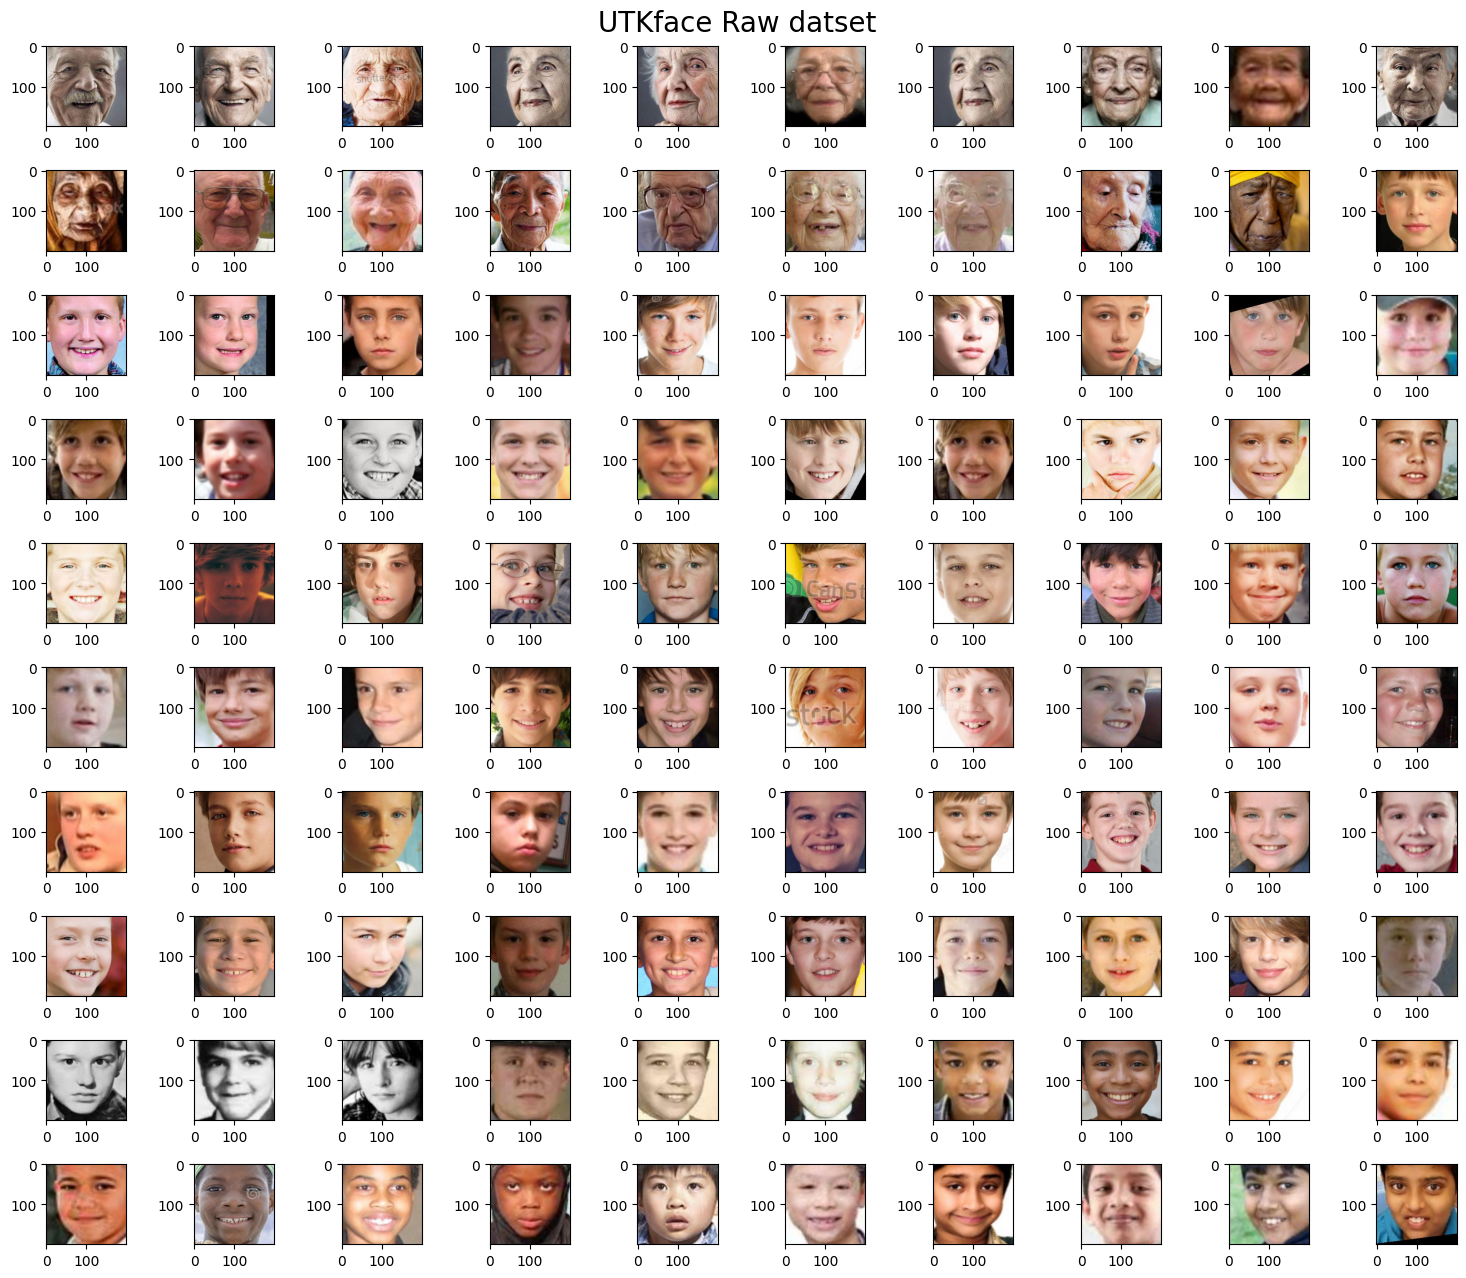

In [43]:
fig1, ax1 = plt.subplots(10, 10, figsize=(15, 13)) 
fig1.suptitle("UTKface Raw datset", fontsize=20)
k = 0
for i in range(10): 
     for j in range(10): 
         ax1[i][j].imshow(cv2.cvtColor(raw_faceImage[k], cv2.COLOR_BGR2RGB)) 
         # ax[i][j].set_title('Label: {}'.format(pixels[k]))
         k += 1         
plt.tight_layout()
plt.show()
#fig1.savefig(figure_dirPath+"UTKFace_rawdataset.png")

### **Step #3**:  Exploratory Data Analysis (EDA) on raw UTKface_rawdataset

#### a) extraction of age and gender Label or annotation on raw UTKface dataset  

**UTK Face Dataset** images have labels embedded in their name, as per the following nomenclature:
#####                                         [age]\_[gender]\_[race]\_[time].jpg 
where


* ***[age]*** is an integer from 0 to 116, indicating the age
* ***[gender]*** is either 0 (male) or 1 (female)
* ***[race]*** is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
* ***[date&time]*** is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace


In [44]:
raw_faceFile=[]
#we only requird on only two imformation age and gender 
raw_age = []
raw_gender = [] 
for img in os.listdir(raw_datasetPath):
  #if int(img.split("_")[0])>=3 and int(img.split("_")[0])<=65:
    raw_faceFile.append(img)
    raw_age.append(np.array(img.split("_")[0],np.uint64))
    raw_gender.append(np.array(img.split("_")[1],np.uint64))

raw_age = np.array(raw_age,np.uint64)
raw_gender = np.array(raw_gender,np.uint64)

print("total # raw_faceFile:",len(raw_faceFile))
print("list of raw_faceFile:", raw_faceFile)
print("total # raw_gender:",len(raw_gender))
print("list of raw_gender:",raw_gender)
print("total # raw_age:",len(raw_age))
print("list of raw_age:",raw_age)

total # raw_faceFile: 23708
list of raw_faceFile: ['100_0_0_20170112213500903.jpg.chip.jpg', '100_0_0_20170112215240346.jpg.chip.jpg', '100_1_0_20170110183726390.jpg.chip.jpg', '100_1_0_20170112213001988.jpg.chip.jpg', '100_1_0_20170112213303693.jpg.chip.jpg', '100_1_0_20170112215032192.jpg.chip.jpg', '100_1_0_20170117195420803.jpg.chip.jpg', '100_1_0_20170119212053665.jpg.chip.jpg', '100_1_2_20170105174847679.jpg.chip.jpg', '100_1_2_20170112213615815.jpg.chip.jpg', '100_1_2_20170112222336458.jpg.chip.jpg', '101_0_0_20170112213500903.jpg.chip.jpg', '101_1_2_20170105174739309.jpg.chip.jpg', '103_0_2_20170112213001988.jpg.chip.jpg', '105_0_0_20170112213001988.jpg.chip.jpg', '105_1_0_20170112213001988.jpg.chip.jpg', '105_1_0_20170112213021902.jpg.chip.jpg', '105_1_0_20170112213507183.jpg.chip.jpg', '105_1_1_20170112213303693.jpg.chip.jpg', '10_0_0_20161220222308131.jpg.chip.jpg', '10_0_0_20170103200329407.jpg.chip.jpg', '10_0_0_20170103200522151.jpg.chip.jpg', '10_0_0_20170103233459275.jp

In [47]:
from PIL import Image
import imagehash
import os

# Function to calculate perceptual hash of an image
def calculate_hash(image_path):
    with Image.open(image_path) as img:
        return imagehash.phash(img)

# Function to find duplicate images in a directory
def find_duplicates(directory):
    hash_dict = {}
    duplicates = []

    # Iterate through each file in the directory
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)

        # Check if the file is an image
        if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            # Calculate hash of the image
            img_hash = calculate_hash(file_path)

            # Check if the hash already exists in the dictionary
            if img_hash in hash_dict:
                duplicates.append((file_path, hash_dict[img_hash]))
            else:
                hash_dict[img_hash] = file_path

    return duplicates

ModuleNotFoundError: No module named 'imagehash'

In [ ]:
# Specify the directory containing the images
image_directory = 'path/to/your/image/directory'

# Find duplicates in the directory
duplicate_pairs = find_duplicates(image_directory)

# Print duplicate pairs
if duplicate_pairs:
    print("Duplicate pairs found:")
    for pair in duplicate_pairs:
        print(pair[0], "<-->", pair[1])
else:
    print("No duplicates found in the directory.")


#### b) Check duplication in  raw dataset file name 

In [46]:
duplicates = len(raw_faceFile) != len(set(raw_faceFile))
print("Duplicates found in the: ", duplicates)

Duplicates found in the:  False


#### c) Check Distribution of gender in raw dataset for any Class Imbalance

In [ ]:
# Count male and female reviews
unique, counts = np.unique(raw_gender, return_counts=True)
gender_distribution = dict(zip(unique, counts))
print("raw_gender_distribution:",gender_distribution)
# Visualize the distribution on the bar bar graph
plt.bar(gender_distribution.keys(), gender_distribution.values(), color=['blue', 'red'])
# Add text annotations to each bar
for i, value in enumerate(gender_distribution.values()):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.title("gender Distribution of UTKFace_rawdataset")
plt.xlabel('gender class')
plt.ylabel('Number of UTKFace_rawdataset image file')
plt.xticks([0, 1], ['male', 'female'])
plt.tick_params(labelleft=True)
plt.tight_layout()
plt.savefig(figure_dirPath+"/gender_Distribution_of_UTKFace_rawdataset.png")
# Display the plot
plt.show()


#### d) Check duplication in  raw dataset file name 

In [ ]:
duplicates = len(raw_faceFile) != len(set(raw_faceFile))
print("Duplicates found in the", raw_datasetPath ,":", duplicates)

#### e) Check Distribution of age for any Class Imbalance

In [ ]:
# Set the figure size
plt.figure(figsize=(15, 7))
# Count male and female reviews
unique, counts = np.unique(raw_age, return_counts=True)
age_distribution = dict(zip(unique, counts))
# Print information about the data
print("List of age:", unique)

print("\nNumber of unique ages:", len(age_distribution))
print("\nage Distribution of UTKFace_rawdataset:", age_distribution)
print("\nMaximum age count:", max(age_distribution.values()))
max_age = max(age_distribution, key=lambda k: age_distribution[k])
print("Age with maximum count:", max_age," year")
# Visualize the distribution
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.bar(age_distribution.keys(), age_distribution.values(), color=colors)#['blue', 'red'])
plt.title("age Distribution of UTKFace_rawdataset")
plt.xlabel('age(1-116 ')
plt.ylabel('Number of UTKFace_rawdataset image file')
plt.tick_params(labelbottom=True)
#plt.xticks([0, 1], ['male', 'female'])
# Limit x and y labels
plt.xlim(-1,117)  # Add buffer to avoid cutting off bars
plt.savefig(figure_dirPath+"age_Distribution_of_UTKFace_rawdataset.png")
plt.show()


#### f) Check descriptive statistics of age of UTKFace_rawdataser 

In [ ]:
# Convert the list to a pandas Series
series = pd.Series(raw_age)
# Get descriptive statistics
descri_stat = (pd.Series(raw_age)).describe()
print( "descriptive statistics in the age", descri_stat)
print("Skewness:", skew(raw_age)) # Calculate skewness
print("Kurtosis:", kurtosis(raw_age))# Calculate kurtosis
# Create a box plot
plt.boxplot(raw_age,vert=0)
# Add labels and title
plt.xlabel('Data')
plt.ylabel('Values')
plt.title('Box Plot')
# Show the plot
plt.show()

### **Step #4**:  extract the extractraw_datasetPath from raw_datasetPath

In [ ]:
raw_faceFile=[]
#we only requird on only two imformation age and gender 
for img in os.listdir(raw_datasetPath):
    if int(img.split("_")[0])>=3 and int(img.split("_")[0])<=65:
        raw_faceFile.append(img)

In [ ]:
extractraw_datasetPath = r"dataset/UTKFace_extractRawDataset"


In [ ]:
# Define paths for your dataset
extractraw_datasetPath = r"dataset/UTKFace_extractRawDataset"

# Ensure the train and test directories exist
os.makedirs(extractraw_datasetPath, exist_ok=True)

# List all image files in the original dataset directory
#image_files = [f for f in os.listdir(raw_datasetPath) if f.endswith(('.png', '.jpg', '.jpeg'))]
#print(type(image_files[0]))

# Copy extractraw images to the train directory
for file in raw_faceFile:
    src_path = os.path.join(raw_datasetPath, file)
    dest_path = os.path.join(extractraw_datasetPath, file)
    print(src_path, dest_path)
    copyfile(src_path, dest_path)


### **Step #5**:  Exploratory Data Analysis  (EDA) on raw UTKface extracteddataset

#### a) extraction of age and gender Label or annotation on extracted UTKface dataset  

**UTK Face Dataset** images have labels embedded in their name, as per the following nomenclature:
#####                                         [age]\_[gender]\_[race]\_[time].jpg 
where


* ***[age]*** is an integer from 0 to 116, indicating the age
* ***[gender]*** is either 0 (male) or 1 (female)
* ***[race]*** is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
* ***[date&time]*** is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace


In [ ]:
extractraw_faceFile=[]
extractraw_faceImage=[]
#we only requird on only two imformation age and gender 
extractraw_age = []
extractraw_gender = [] 
for img in os.listdir(extractraw_datasetPath):
  if int(img.split("_")[0])>=3 and int(img.split("_")[0])<=65:
    extractraw_faceImage.append(np.array(cv2.imread(str(extractraw_datasetPath)+"/"+str(img),-1)))   
    extractraw_faceFile.append(img)
    extractraw_age.append(np.array(img.split("_")[0],np.uint64))
    extractraw_gender.append(np.array(img.split("_")[1],np.uint64))

extractraw_age = np.array(extractraw_age,np.uint64)
extractraw_gender = np.array(extractraw_gender,np.uint64)

print("total # extractraw_faceFile:",len(extractraw_faceFile))
print("list of extractraw_faceFile:", extractraw_faceFile)
print("total # extractraw_gender:",len(extractraw_gender))
print("list of extractraw_gender:",extractraw_gender)
print("total # extractraw_age:",len(extractraw_age))
print("list of extractraw_age:",extractraw_age)
print("total # extractraw_faceImage:",len(extractraw_faceImage))
print("list of extractraw_faceImage:", extractraw_faceImage)

#### b) Check duplication in  raw dataset file name 

In [ ]:
duplicates = len(extractraw_faceFile) != len(set(extractraw_faceFile))
print("Duplicates found in the", extractraw_datasetPath ,":", duplicates)

#### c) Check Distribution of gender in raw dataset for any Class Imbalance

In [ ]:
# Count male and female reviews
unique, counts = np.unique(extractraw_gender, return_counts=True)
gender_distribution = dict(zip(unique, counts))
print("raw_gender_distribution:",gender_distribution)
# Visualize the distribution on the bar bar graph
plt.bar(gender_distribution.keys(), gender_distribution.values(), color=['blue', 'red'])
# Add text annotations to each bar
for i, value in enumerate(gender_distribution.values()):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.title("gender Distribution of UTKFace_extractrawdataset")
plt.xlabel('gender class')
plt.ylabel('Number of UTKFace_extractrawdataset image file')
plt.xticks([0, 1], ['male', 'female'])
plt.tick_params(labelleft=True)
plt.tight_layout()
plt.savefig(figure_dirPath+"/gender_Distribution_of_UTKFace_extractrawdataset.png")
# Display the plot
plt.show()


#### d) Check Distribution of age for any Class Imbalance

In [ ]:
# Set the figure size
plt.figure(figsize=(15, 7))
# Count male and female reviews
unique, counts = np.unique(extractraw_age, return_counts=True)
age_distribution = dict(zip(unique, counts))
# Print information about the data
print("List of age:", unique)

print("\nNumber of unique ages:", len(age_distribution))
print("\nage Distribution of UTKFace_extractrawdataset:", age_distribution)
print("\nMaximum age count:", max(age_distribution.values()))
max_age = max(age_distribution, key=lambda k: age_distribution[k])
print("Age with maximum count:", max_age," year")
# Visualize the distribution
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.bar(age_distribution.keys(), age_distribution.values(), color=colors)#['blue', 'red'])
plt.title("age Distribution of UTKFace_extractrawdataset")
plt.xlabel('age(1-116 ')
plt.ylabel('Number of UTKFace_extractrawdataset image file')
plt.tick_params(labelbottom=True)
#plt.xticks([0, 1], ['male', 'female'])
# Limit x and y labels
plt.xlim(-1,117)  # Add buffer to avoid cutting off bars
plt.savefig(figure_dirPath+"age_Distribution_of_UTKFace_rawdataset.png")
plt.show()


#### e) Histrogram for the age distribution by only given bin 

In [ ]:
# computer a histotgram for the age classificaiton but nned t0 calculated the number and size of  bin for  calculated the number and size of  bin  
#decide on the number of bins of a Histogram?  
plt.hist(extractraw_age, bins=12, alpha=0.7,edgecolor='black')
plt.title('Histogram of age extractdDataset')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### f) compute number and size of bin for Histrogram of age distribution using  data binning technique (square_root_bins, sturges_bins ,scotts_bins, freedman_diaconis_bins and doanes_bins) 

In [ ]:

def square_root_bins(data):
    return int(np.sqrt(len(data)))

def sturges_bins(data):
    return int(1 + np.log2(len(data)))

def scotts_bins(data):
    sigma = np.std(data)
    return int((np.max(data) - np.min(data)) / (3.5 * sigma / np.cbrt(len(data))))

def freedman_diaconis_bins(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    return int((np.max(data) - np.min(data)) / (2 * iqr / np.cbrt(len(data))))

def doanes_bins(data):
    n = len(data)
    g1 = skew(data)
    sigma_g1 = np.sqrt((6 * (n - 2)) / ((n + 1) * (n + 3)))
    return int(1 + np.log2(n) + np.log2(1 + np.abs(g1) / sigma_g1))

In [ ]:
# Calculate number of bins using each method
num_bins_square_root = square_root_bins(extractraw_age)
num_bins_sturges = sturges_bins(extractraw_age)
num_bins_scotts = scotts_bins(extractraw_age)
num_bins_freedman_diaconis = freedman_diaconis_bins(extractraw_age)
num_bins_doanes = doanes_bins(extractraw_age)

# Create histograms with different bin selections
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.hist(extractraw_age, bins=num_bins_square_root, edgecolor='black')
#print(SRR_bin_edges)
plt.title('Square Root Rule')
plt.subplot(2, 3, 2)
plt.hist(extractraw_age, bins=num_bins_sturges, edgecolor='black')
#print(bin_edges)
plt.title('Sturges Formula')

plt.subplot(2, 3, 3)
plt.hist(extractraw_age, bins=num_bins_scotts, edgecolor='black')
#print(bin_edges)
plt.title("Scott's Rule")

plt.subplot(2, 3, 4)
plt.hist(extractraw_age, bins=num_bins_freedman_diaconis, edgecolor='black')
#print(bin_edges)
plt.title('Freedman-Diaconis Rule')

plt.subplot(2, 3, 5)
Doane_Numofbine_edge= plt.hist(extractraw_age, bins=num_bins_doanes, edgecolor='black')
plt.title("Doane's Formula")
plt.tight_layout()
plt.show()

print ("Doane_Numofbine_edge_value: ",Doane_Numofbine_edge[0])
print ("\nDoane_Numofbine_edge: ",(Doane_Numofbine_edge[1]))

In [ ]:
print ("num_bins_doanes: ",num_bins_doanes)
print ("\nnum_bins_doanes_value: ", (Doane_Numofbine_edge[1]))
rounded_doanes_binEdge = [round(num) for num in (Doane_Numofbine_edge[1])]
print("\nrounded_doanes_binEdge: ",rounded_doanes_binEdge)

# Exclude specific intervals
#excluded_intervals = [76, 82, 87, 93, 99, 104, 110]
# Filter out excluded intervals
#filtered_classbin = [interval for interval in rounded_doanes_binEdge if interval not in excluded_intervals]
# Define intervals
#print("\nfiltered_classbin: ",filtered_classbin)


In [ ]:
print("rounded_doanes_binEdge: ",rounded_doanes_binEdge)
first_index = 0 # First index
last_index = len(rounded_doanes_binEdge) - 1 # Last index

first=rounded_doanes_binEdge[first_index]
last=rounded_doanes_binEdge[last_index]
remained_list = rounded_doanes_binEdge[1:-1]
remained_list_plus_one = [x + 1 for x in remained_list]
modified_rounded_doanes_binEdge= [first]+remained_list_plus_one+[last]
#print(first,last,remained_list_plus_one)
print("\nmodified_rounded_doanes_binEdge: ",modified_rounded_doanes_binEdge)
%store modified_rounded_doanes_binEdge

In [ ]:
# computer a histotgram for the age classificaiton but nned t0 calculated the number and size of  bin for  calculated the number and size of  bin  
#decide on the number of bins of a Histogram?
#[1 2 3 4] bin are [1 2) [2 3) [3 4] 
hist=plt.hist(extractraw_age, bins=modified_rounded_doanes_binEdge,  alpha=0.7, edgecolor='black')
print("no of file image: ",hist[0])
print("interval of bin: ",hist[1])

plt.title('age Distribution histrogram of UTKFace_extractdataset')
plt.xlabel('age interval Value')
plt.ylabel('Frequency of UTKFace_extractdataset image')
plt.grid(True)
plt.savefig(figure_dirPath+"age_Distribution_histrogram_of_UTKFace_extractrawdataset.png")
plt.show()


#### e) Check two-way Distribution of age and gender for any two-Class Imbalance

In [ ]:
def countGender_MF(face_gender):   
    unique, counts = np.unique(face_gender, return_counts=True)
    #print("list of age=", unique)      
    processedgender_distribution = dict(zip(unique, counts))
    #print("raw_gender:",processedgender_distribution)
    return processedgender_distribution 

In [ ]:
#print("\nrounded_doanes_binEdge: ",rounded_doanes_binEdge)

""" ## define the class for aage interval
age_classname= ['child_1_7',
            'kid_8_12',
            'teenager_13_18',
            'EarlyAdulthood_19_24',
            'EarlyAdulthood_25_30',
            'YoungAdulthood_31_36',
            'YoungAdulthood_37_41',
            'middleAdulthood_42_47',
            'middleAdulthood_48_53',
            'middleAdulthood_54_58',
            'middleAdulthood_59_64',
            'middleAdulthood_65_70',
            #'middleAdulthood_71_76',
            "senior_71_116"]
            # "senior_77_82",
            # "senior_83_87",
            # "senior_88_93",
            # "senior_94_99",
            # "senior_100_104",
            # "senior_105_110",
            # "senior_111_116"] """
#%store age_classname


In [ ]:
age_classname= ['child_3_6',
            'kid_7_12',
            'teenager_13_19',
            'EarlyAdulthood_20_26',
            'EarlyAdulthood_27_32',
            'YoungAdulthood_33_40',
            'middleAdulthood_41_45',
            'middleAdulthood_46_50',
            'middleAdulthood_51_56',
            'senior_57_65']
%store age_classname


In [ ]:
classname_dict_ageGender={}
lower_agelimit=[]
upper_agelimit=[]

for agevariable in age_classname:
    lower_agelimit.append(int(agevariable.split("_")[1]))
    upper_agelimit.append(int(agevariable.split("_")[2]))

print ("lower_agelimit: ",lower_agelimit)
print ("upper_agelimit: ",upper_agelimit)

%store lower_agelimit
%store upper_agelimit

age_bagg=[]
gender_bagg=[]

for classe,lowerage,upperage in zip(age_classname,lower_agelimit,upper_agelimit):
    #print(classe,lowerage,upperage)
    for age,gender in zip(extractraw_age,extractraw_gender):
        if age>=(lowerage) and age<=upperage:
            age_bagg.append(age)
            gender_bagg.append(gender)
            classname_dict_ageGender[(classe)]=[len(age_bagg), (countGender_MF(gender_bagg))]  
    age_bagg.clear()
    gender_bagg.clear()
    
print("\nclassname_dict: ",classname_dict_ageGender)
print("\n")

# Initialize lists to store data
row = []
# Iterate over all age groups and their counts
for age_group, count_data in classname_dict_ageGender.items():
    total_count = count_data[0]
    male_count = count_data[1][0]
    female_count = count_data[1][1]
    # Append data to list
    row.append({'ageGroup_L_H': age_group,'total_face': total_count, 'Male_Count': male_count, 'Female_Count': female_count})

# Create DataFrame from the list of dictionaries
twoWay_table = pd.DataFrame(row)
# Display DataFrame
print("two-way gender-ageGroup Distribution:\n ",twoWay_table)
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))  # Set the figure size to width=10 and height=6
twoWay_table.plot.bar(x='ageGroup_L_H', ax=ax, rot=75, color=['green', 'blue', 'red'])
ax.set_xlabel("Age Group")  # Set the label for the x-axis
ax.set_ylabel("# of face image")  # Set the label for the x-axis

plt.title('gender -- ageGroup Distribution  of UTKFace_extractrawdataset')

print("\n")
summary_dict1={ "total_face":twoWay_table['total_face'].sum(), "total_MaleCount": twoWay_table['Male_Count'].sum(), "total_FemaleCount":twoWay_table['Female_Count'].sum()}
#print(summary_dict)
# Convert summary_dict to DataFrame
total_summary_table = pd.DataFrame([summary_dict1])
print(total_summary_table)
fig.savefig(figure_dirPath+"gender-ageGroup_Distribution_of_UTKFace_extractrawdataset.png")


#### c) Split processed_UTKdataset file and copy into train, test and validation dataset 

In [ ]:

# Define paths for your dataset
train_dirPath = r"dataset/UTKFace_trainDataset"
test_dirPath = r"dataset/UTKFace_testDataset"
val_dirPath= r"dataset/UTKFace_valDataset"


# Ensure the train and test directories exist
os.makedirs(train_dirPath, exist_ok=True)
os.makedirs(test_dirPath, exist_ok=True)
os.makedirs(val_dirPath, exist_ok=True)


# List all image files in the original dataset directory
image_files = [f for f in os.listdir(extractraw_datasetPath) if f.endswith(('.png', '.jpg', '.jpeg'))]
#print(image_files)


# Split the data into train and test sets 
# Split data into train and test sets (80% train, 20% test)
train_files, test_files = train_test_split(image_files, test_size=0.4, random_state=100)
# Split test set into test and validation sets (50% test, 50% validation)
test_files, val_files = train_test_split(test_files, test_size=0.5, random_state=100)


# Output the sizes of each set
print("totalprocessed_faceImage: ", len(extractraw_faceImage))
print("Train set size:", len(train_files))
print("Validation set size:", len(val_files))
print("Test set size:", len(test_files))


In [ ]:
# Copy training images to the train directory
for file in train_files:
    src_path = os.path.join(extractraw_datasetPath, file)
    dest_path = os.path.join(train_dirPath, file)
    copyfile(src_path, dest_path)

# Copy test images to the test directory
for file in test_files:
    src_path = os.path.join(extractraw_datasetPath, file)
    dest_path = os.path.join(test_dirPath, file)
    copyfile(src_path, dest_path)
    
# # Copy test images to the validation directory
for file in val_files:
    src_path = os.path.join(extractraw_datasetPath, file)
    dest_path = os.path.join(val_dirPath, file)
    copyfile(src_path, dest_path)


#### e) Check two-way Distribution of age and gender for any two-Class Imbalance in utkface_traindataset

In [ ]:

train_age = []
train_gender = [] 

for img in os.listdir(train_dirPath):
  train_age.append(np.array(img.split("_")[0],np.uint64))
  train_gender.append(np.array(img.split("_")[1],np.uint64))

train_age = np.array(train_age,np.uint64)
train_gender = np.array(train_gender,np.uint64)

print("lenght of UTKFace_trainDataset gender:",len(train_gender))
print("train_gender list:",train_gender)
print("lenght of UTKFace_trainDataset aga:", len(train_age))
print("train_age list:",train_age)

In [ ]:
classname_dict_ageGender={}
lower_agelimit=[]
upper_agelimit=[]

for agevariable in age_classname:
    lower_agelimit.append(int(agevariable.split("_")[1]))
    upper_agelimit.append(int(agevariable.split("_")[2]))

print ("lower_agelimit: ",lower_agelimit)
print ("upper_agelimit: ",upper_agelimit)

%store lower_agelimit
%store upper_agelimit

age_bagg=[]
gender_bagg=[]

for classe,lowerage,upperage in zip(age_classname,lower_agelimit,upper_agelimit):
    #print(classe,lowerage,upperage)
    for age,gender in zip(train_age,train_gender):
        if age>=(lowerage) and age<=upperage:
            age_bagg.append(age)
            gender_bagg.append(gender)
            classname_dict_ageGender[(classe)]=[len(age_bagg), (countGender_MF(gender_bagg))]  
    age_bagg.clear()
    gender_bagg.clear()
    
print("\nclassname_dict: ",classname_dict_ageGender)
print("\n")

# Initialize lists to store data
row = []
# Iterate over all age groups and their counts
for age_group, count_data in classname_dict_ageGender.items():
    total_count = count_data[0]
    male_count = count_data[1][0]
    female_count = count_data[1][1]
    # Append data to list
    row.append({'ageGroup_L_H': age_group,'total_face': total_count, 'Male_Count': male_count, 'Female_Count': female_count})

# Create DataFrame from the list of dictionaries
twoWay_table = pd.DataFrame(row)
# Display DataFrame
print("two-way gender-ageGroup Distribution in traindataset:\n ",twoWay_table)
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))  # Set the figure size to width=10 and height=6
twoWay_table.plot.bar(x='ageGroup_L_H', ax=ax, rot=75, color=['green', 'blue', 'red'])
ax.set_xlabel("Age Group")  # Set the label for the x-axis
ax.set_ylabel("# of face image")  # Set the label for the x-axis

plt.title('gender -- ageGroup Distribution  of UTKFace_traindataset')

print("\n")
summary_dict1={ "total_face":twoWay_table['total_face'].sum(), "total_MaleCount": twoWay_table['Male_Count'].sum(), "total_FemaleCount":twoWay_table['Female_Count'].sum()}
#print(summary_dict)
# Convert summary_dict to DataFrame
total_summary_table = pd.DataFrame([summary_dict1])
print(total_summary_table)
fig.savefig(figure_dirPath+"gender-ageGroup_Distribution_of_UTKFace_extractrawdataset.png")


### **Step #5**: image argumentation on UTKFace_extractdataset

#### a) create a folder for store argumented image

In [ ]:
argumentraw_datasetPath = r'dataset//UTKFace_argTrainDataset'
##############
# Two lists of strings
gender_classname = ['male', 'female']
# Initialize an empty list to store the combined strings
age_genderClassName = []
# Iterate over each element in age_classname
for age_class in age_classname:
    # Iterate over each element in gender_classname
    for gender_class in gender_classname:
        # Concatenate the elements and append to the combined list
        age_genderClassName.append(age_class +"_"+gender_class)

print("age_genderClassName: ", age_genderClassName)
print("\n")
################################
for classname in age_genderClassName:
    folder_path = os.path.join(argumentraw_datasetPath, classname)
    #os.makedirs(folder_path)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    else:
        print(f"Folder '{folder_path}' already exists.")

#### b) create a two way frequency table fro the need of image argumentation in the class

In [ ]:
# Create DataFrame from the list of dictionaries
twoWay_table = pd.DataFrame(row)
# Display DataFrame
print("two-way gender-ageGroup Distribution:\n ",twoWay_table)
# To find the maximum value across all columns
max_value_across_all_columns = max(twoWay_table["Male_Count"].values.max() ,twoWay_table["Female_Count"].values.max())
print("\nmax_value_across_all_columns",max_value_across_all_columns)

In [ ]:
# Initialize lists to store data
arg_imageNeed = []
# Iterate over all age groups and their counts
for age_group, count_data in classname_dict_ageGender.items():
    male_count_argneed = max_value_across_all_columns-count_data[1][0]
    female_count_argneed = max_value_across_all_columns-count_data[1][1]
    total_count_argneed = male_count_argneed+female_count_argneed
    # Append data to list
    arg_imageNeed.append({'ageGroup_L_H': age_group,'totalFaceArgneed': total_count_argneed, 'Maleargneed': (male_count_argneed), 'Femaleargneed':(female_count_argneed)})

# Create DataFrame from the list of dictionaries
arg_imageNeed_twoWayTable = pd.DataFrame(arg_imageNeed)
# Display DataFrame
print("two-way gender-ageGroup Distribution for arg_imageNeed:\n ",arg_imageNeed_twoWayTable)
totalArgNeed_summary_dict1=[]
totalArgNeed_summary_dict1.append({"total_face_argneed":(arg_imageNeed_twoWayTable['totalFaceArgneed'].sum()), "total_MaleCount_argneed": (arg_imageNeed_twoWayTable['Maleargneed'].sum()), "total_FemaleCount_argneed":(arg_imageNeed_twoWayTable['Femaleargneed'].sum())})
totalArgNeed_summary_Table = pd.DataFrame(totalArgNeed_summary_dict1)
# Display DataFrame
print("\ntotalArgNeed_summary_Table:\n ",totalArgNeed_summary_Table)


#### c) generated image argumentation in the each class

In [ ]:

# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=100,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0.2,
    zoom_range=0,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# 3 6 1
#3 6 2
print(lower_agelimit)
print(upper_agelimit)

print(arg_imageNeed[0]["Femaleargneed"])

In [ ]:
kkkkk

In [ ]:
# Initialize a variable
current_iter = 0
change_LHrange=0

# Loop indefinitely
while change_LHrange<=9:
    while True:
        #print("\ncurrent_iter:", current_iter)# Increment the value
        maleListArg=[]
        femaleListArg=[]
        for img in os.listdir(extractraw_datasetPath): #male L-H year
            if int(img.split("_")[0])>=lower_agelimit[change_LHrange] and int(img.split("_")[0])<=upper_agelimit[change_LHrange] and int(img.split("_")[1])==0:
                maleListArg.append(img)
        print("lenght_maleListArg_"+str(lower_agelimit[change_LHrange])+"_"+str(upper_agelimit[change_LHrange])+"lenght: ",len(maleListArg))
        #print((maleListArg))
        # Pick a random number from the list
        random_malefile= random.choice(maleListArg)
        print("random maleListArg_:",random_malefile)
        argumentraw_male_datasetPath = r'dataset//UTKFace_argTrainDataset/'+age_classname[change_LHrange]+"_male"
        #print("argumentraw_male_datasetPath:",argumentraw_male_datasetPath)
        argumentraw_male_totalFiles = len(os.listdir(argumentraw_male_datasetPath))
        print("argumentraw_male_totalFiles:",argumentraw_male_totalFiles,"total:("+str(arg_imageNeed[change_LHrange]["Maleargneed"])+") "+argumentraw_male_datasetPath)
        # Load and preprocess a sample image
        img_path = os.path.join(extractraw_datasetPath, random_malefile)#"picture/3_0_0_20161219154705684.jpg.jpg"
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(200, 200))
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        #i = 0
        #Pick a random number from the list
        # Generate augmented images and save them
        current_iter += 1  
        for batch in datagen.flow(x, batch_size=1, save_to_dir=argumentraw_male_datasetPath, save_prefix=random_malefile, save_format='jpeg'):
                #i += 1
                #if i % 1 == 0:  # Generate 1 augmented images
            break # break the generation loop
        #(50-1):
        if argumentraw_male_totalFiles>=((arg_imageNeed[change_LHrange]["Maleargneed"])-1):
            print("Value reached "+str((arg_imageNeed[change_LHrange]["Maleargneed"])) +" Exiting loop.")
            break  # Exit the loop

    change_LHrange+=1
    print("Loop ended.")


In [ ]:
# Initialize a variable
current_iter = 0
change_LHrange=0

# Loop indefinitely
while change_LHrange<=9:
    while True:
        #print("\ncurrent_iter:", current_iter)# Increment the value
        femaleListArg=[]
        for img in os.listdir(extractraw_datasetPath): #female L-H year
            if int(img.split("_")[0])>=lower_agelimit[change_LHrange] and int(img.split("_")[0])<=upper_agelimit[change_LHrange] and int(img.split("_")[1])==1:
                femaleListArg.append(img)
        
        #print("lenght_femaleListArg_"+str(lower_agelimit[change_LHrange])+"_"+str(upper_agelimit[change_LHrange])+"lenght: ",len(femaleListArg))
        print(len(femaleListArg))
        # Pick a random number from the list
        random_femalefile= random.choice(femaleListArg)
        print("random feListArg :",random_femalefile)
        argumentraw_female_datasetPath = r'dataset//UTKFace_argTrainDataset/'+age_classname[change_LHrange]+"_female"
        #print("argumentraw_male_datasetPath:",argumentraw_male_datasetPath)
        argumentraw_female_totalFiles = len(os.listdir(argumentraw_female_datasetPath))
        print("argumentraw_female_totalFiles:",argumentraw_female_totalFiles,"total:("+str(arg_imageNeed[change_LHrange]["Femaleargneed"])+") "+argumentraw_female_datasetPath)
        # Load and preprocess a sample image
        img_path = os.path.join(extractraw_datasetPath, random_femalefile)#"picture/3_0_0_20161219154705684.jpg.jpg"
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(200, 200))
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        #i = 0
        #Pick a random number from the list
        # Generate augmented images and save them
        current_iter += 1  
        for batch in datagen.flow(x, batch_size=1, save_to_dir=argumentraw_female_datasetPath, save_prefix=random_femalefile, save_format='jpeg'):
                #i += 1
                #if i % 1 == 0:  # Generate 1 augmented images
            break # break the generation loop
        #(50-1):
        if argumentraw_female_totalFiles>=((arg_imageNeed[change_LHrange]["Femaleargneed"])-1):
            print("Value reached "+str((arg_imageNeed[change_LHrange]["Femaleargneed"])) +" Exiting loop.")
            break  # Exit the loop

    change_LHrange+=1
    print("Loop ended.")


### **Step #6**: combine all the dataset to  UTKFace_completeRawDataset

#### a) combine the UTKFace_argumentRawDataset to  UTKFace_completeRawDataset

In [ ]:
import os
import shutil

completeTrain_datasetPath =  "dataset//UTKFace_completeTrainDataset/"
# Create the destination folder if it doesn't exist
if not os.path.exists(completeTrain_datasetPath):
    os.makedirs(completeTrain_datasetPath)

for root, dirs, files in os.walk(argumentraw_datasetPath):
    for file in files:
        src_path = os.path.join(root, file)
        target_path = os.path.join(completeTrain_datasetPath, file)
        shutil.copy(src_path, target_path)


#### b) combine the UTKFace_extractRawDataset to  UTKFace_completeRawDataset

In [ ]:
# Function to copy files from source folders to destination folder
def copy_files(source_folder, destination_folder):
    for filename in os.listdir(source_folder):
        source_file = os.path.join(source_folder, filename)
        destination_file = os.path.join(destination_folder, filename)
        shutil.copy(source_file, destination_file)

In [ ]:
copy_files(train_dirPath, completeTrain_datasetPath)

In [ ]:
kkkkk

### **Step #7**: save detail in in summaryfile in  xlsx file 

In [ ]:
from openpyxl import Workbook
from openpyxl.drawing.image import Image

# Generating writer engine
writer = pd.ExcelWriter(summary_filepath, engine='openpyxl')

# Add a plot image to the worksheet
img = Image((figure_dirPath+"/gender_Distribution_of_UTKFace_rawdataset.png"))  # Replace 'your_plot.png' with the path to your plot image
sheet.add_image(img, 'A1')     # Add the image to cell A1

# Save the workbook
workbook.save(summary_filepath)  # Save the Excel file as 'output.xlsx'
workbook.close()

In [ ]:

# Adding dataframes to Excel as new sheets
#architecture_df.to_excel(writer, sheet_name='cnn_architecture', index=False)
#history_df.to_excel(writer, sheet_name='training_log', index=True,index_label='Epoch')
# Saving changes and closing writer
writer.book.save(summary_filepath)#"modelsummary.xlsx")
writer.close()
